In [159]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Inspect the database to get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Get a list of column names and types for the table named 'measurement'
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Get a list of column names and types for the table named 'station'
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Find the most recent date in the dataset.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

In [205]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
latest_year_date = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= latest_year_date).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores_db = pd.DataFrame(prcp_scores, columns=['Date', 'Precipitation'])
prcp_scores_db.set_index('Date', inplace = True)

# Sort the dataframe by date
prcp_scores_db = prcp_scores_db.sort_index(ascending = True)

# Display the database
prcp_scores_db.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


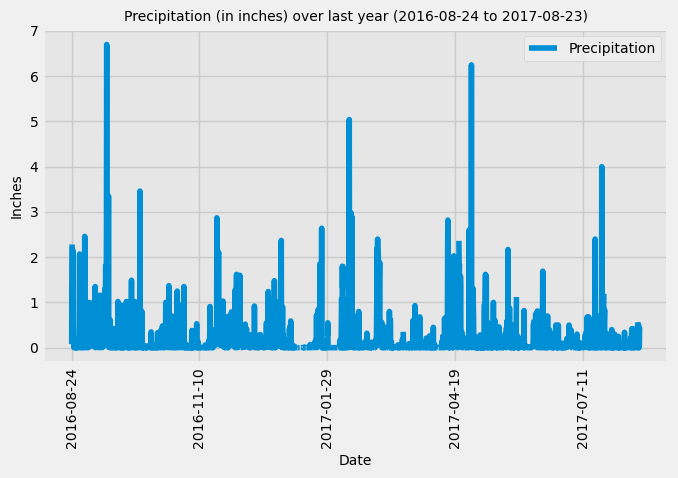

In [228]:
# Use Pandas Plotting with Matplotlib to plot the data
Fig1 = prcp_scores_db.plot(figsize=(7,5), fontsize=10)


# Fig1.xaxis.set_major_locator(ticker.AutoLocator())

Fig1.set_facecolor('0.9')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=1.0)
plt.xticks(rotation=90)
plt.xlabel("Date", size=10)
plt.ylabel("Inches", size=10)
plt.title("Precipitation (in inches) over last year (2016-08-24 to 2017-08-23)", size=10)

plt.tight_layout()

plt.show()

In [174]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_scores_db.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [179]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()

# Display the number of stations
print(f"There are {total_stations} stations in the dataset.")

There are 9 stations in the dataset.


In [180]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [189]:
# Which station id has the greatest number of observations?
most_active_station = active_stations[0][0]

# Show the most active station
print(f"{most_active_station} has the greatest number of observations.")

USC00519281 has the greatest number of observations.


In [204]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Create list for temperature values
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

# Calculate the temperature values
most_active_station_temperatures = session.query(*sel).\
                                   filter(Measurement.station == most_active_station).all()

# Show the temperature values
print(f"The lowest temperature at {most_active_station} is {most_active_station_temperatures[0][0]} Fahrenheit.")
print(f"The highest temperature at {most_active_station} is {most_active_station_temperatures[0][1]} Fahrenheit.")
print(f"The average temperature at {most_active_station} is {most_active_station_temperatures[0][2]} Fahrenheit.")

The lowest temperature at USC00519281 is 54.0 Fahrenheit.
The highest temperature at USC00519281 is 85.0 Fahrenheit.
The average temperature at USC00519281 is 71.66378066378067 Fahrenheit.


In [213]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_data = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= latest_year_date).\
                    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame
station_temp_db = pd.DataFrame(station_temp_data)

# Display the dataset
station_temp_db.head()


,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0


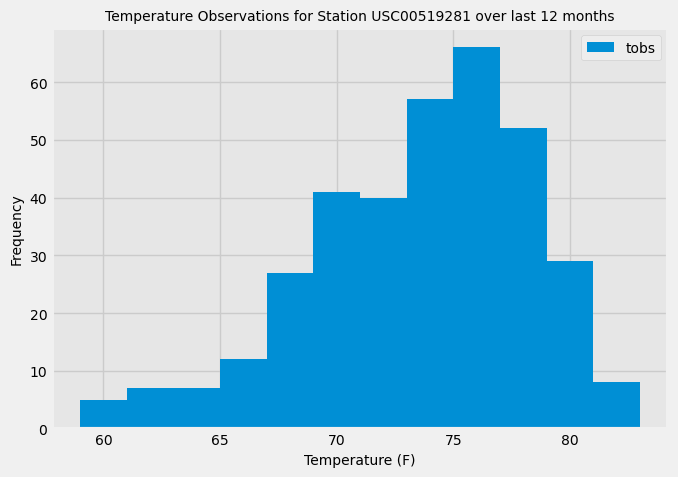

In [230]:
# Plot the histogram
Fig2 = station_temp_db.plot(kind='hist', bins=12, fontsize=10, figsize=(7,5))

Fig2.set_facecolor('0.9')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=1.0)

plt.xlabel("Temperature (F)", size=10)
plt.ylabel("Frequency", size=10)
plt.title("Temperature Observations for Station USC00519281 over last 12 months", size=10)

plt.tight_layout()

plt.show()

# Close session

In [ ]:
# Close Session
session.close()